<a href="https://colab.research.google.com/github/punnarat-w/Yomriver_analysis/blob/main/ForecastingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Retrieving Data

In [1]:
# importing pandas library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# download description file
!gdown --id 1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f

Downloading...
From: https://drive.google.com/uc?id=1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f
To: /content/st.csv
100% 20.8k/20.8k [00:00<00:00, 48.6MB/s]


In [3]:
def getData(filename):
  data = pd.read_csv(filename)
  # data['Datetime'] = pd.to_datetime(data['Datetime'])
  # data = data.set_index('Datetime')
  return data

In [4]:
description = getData('st.csv')
description

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
0,BDLH,ทต.ลานหอย,17.008562,99.582995,ลานหอย,บ้านด่านลานหอย,สุโขทัย,ภาคเหนือ,R,NaN
1,SAMN,ทต.สามง่าม,16.512774,100.208275,สามง่าม,สามง่าม,พิจิตร,ภาคเหนือ,R,NaN
2,SNGT,อบต.บ้านกลาง,18.482018,100.177530,บ้านกลาง,สอง,แพร่,ภาคเหนือ,R,NaN
3,KPPT,อบจ.กำแพงเพชร,16.410858,99.521990,อ่างทอง,เมืองกำแพงเพชร,กำแพงเพชร,ภาคเหนือ,R,NaN
4,PKTI,ทต.พรานกระต่าย,16.653760,99.575782,พรานกระต่าย,พรานกระต่าย,กำแพงเพชร,ภาคเหนือ,R,NaN
...,...,...,...,...,...,...,...,...,...,...
109,VLGE13,ชุมแสงสงคราม,16.858560,100.059642,ชุมแสงสงคราม,บางระกำ,พิษณุโลก,ภาคเหนือ,W,NaN
110,VLGE15,ชุมชนหนองปิ้งไก่,16.434798,99.367315,นาบ่อคำ,เมืองกำแพงเพชร,กำแพงเพชร,ภาคเหนือ,R,NaN
111,VLGE12,นครป่าหมาก,16.623374,100.369210,นครป่าหมาก,บางกระทุ่ม,พิษณุโลก,ภาคเหนือ,W,NaN
112,TBW014,สะพานข้ามคลองเกรียงไกร,15.843182,100.211475,บางเคียน,ชุมแสง,นครสวรรค์,ภาคเหนือ,W,NaN


In [5]:
description['region'].value_counts()

R    77
W    37
Name: region, dtype: int64

Finding the code of chosen stations

In [6]:
description[description['name'] == 'ทต.เชียงม่วน']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
32,CGMN,ทต.เชียงม่วน,18.893837,100.28784,เชียงม่วน,เชียงม่วน,พะเยา,ภาคเหนือ,R,NaN


In [7]:
description[description['name'] == 'อบต.วังชิ้น']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
25,WCHN,อบต.วังชิ้น,17.87883,99.61927,วังชิ้น,วังชิ้น,แพร่,ภาคเหนือ,R,NaN


In [8]:
description[description['name'] == 'โรงฆ่าสัตว์ ทม.สวรรคโลก']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
17,SWKL,โรงฆ่าสัตว์ ทม.สวรรคโลก,17.31681,99.825146,เมืองสวรรคโลก,สวรรคโลก,สุโขทัย,ภาคเหนือ,R,NaN


##Download data

In [9]:
# download station file
!gdown --id 1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
!gdown --id 1dj14nux3FyViM9heQwHxio1QZleZoZJx
!gdown --id 1hT_L86beygC_OQ1jMushxeDga8ZBM9Js

Downloading...
From: https://drive.google.com/uc?id=1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
To: /content/CGMN.csv
3.72MB [00:00, 57.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dj14nux3FyViM9heQwHxio1QZleZoZJx
To: /content/WCHN.csv
3.65MB [00:00, 56.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hT_L86beygC_OQ1jMushxeDga8ZBM9Js
To: /content/SWKL.csv
3.69MB [00:00, 111MB/s]


In [10]:
north_df = getData('CGMN.csv')
mid_df = getData('WCHN.csv')
south_df = getData('SWKL.csv')

In [11]:
# download storm file
!gdown --id 1Sj-7RPCg6Ul4CWFdZ-hLAiWpVCzf-2_L

Downloading...
From: https://drive.google.com/uc?id=1Sj-7RPCg6Ul4CWFdZ-hLAiWpVCzf-2_L
To: /content/Storm_2010-2020.csv
100% 17.8k/17.8k [00:00<00:00, 14.9MB/s]


In [12]:
storm_df = getData('Storm_2010-2020.csv')
# storm_df

In [13]:
# download forest file
!gdown --id 1AYwTBFuIVJJ0QGDu1lALIQDmwpIKNO8P

Downloading...
From: https://drive.google.com/uc?id=1AYwTBFuIVJJ0QGDu1lALIQDmwpIKNO8P
To: /content/ForestNorth_2013-2019.csv
100% 1.57k/1.57k [00:00<00:00, 2.64MB/s]


In [14]:
forest_df = getData('ForestNorth_2013-2019.csv')
forest_df

,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,2019,ตอนบน,"19,254,452.30","12,103,104.21",182.76,117.24
1,2019,ตอนกลาง,"4,051,912.64","2,627,401.47",64.84,35.16
2,2019,ตอนล่าง,"84,183,434.55","41,661,864.73",565.03,734.97
3,2018,ตอนบน,"19,254,452.30","12,128,810.16",183.14,116.86
4,2018,ตอนกลาง,"4,051,912.64","2,623,909.73",64.76,35.24
5,2018,ตอนล่าง,"84,183,434.55","41,728,212.55",565.64,734.36
6,2017,ตอนบน,"19,254,452.30","12,115,729.16",182.92,117.08
7,2017,ตอนกลาง,"4,051,912.64","2,610,863.30",64.44,35.56
8,2017,ตอนล่าง,"84,183,434.55","41,652,816.09",564.00,736.00
9,2016,ตอนบน,"19,254,452.30","12,177,949.25",183.89,116.11


#Data Preparation

##Combining data

###Merging data sets

In [15]:
def insertkey(df):
  # insert column key in df for merge data
  n_10 = df[df.date.str.contains('2010')]
  n_10.insert(0, "Key", "10")
  n_11 = df[df.date.str.contains('2011')]
  n_11.insert(0, "Key", "11")
  n_12 = df[df.date.str.contains('2012')]
  n_12.insert(0, "Key", "12")
  n_13 = df[df.date.str.contains('2013')]
  n_13.insert(0, "Key", "13")
  n_14 = df[df.date.str.contains('2014')]
  n_14.insert(0, "Key", "14")
  n_15 = df[df.date.str.contains('2015')]
  n_15.insert(0, "Key", "15")
  n_16 = df[df.date.str.contains('2016')]
  n_16.insert(0, "Key", "16")
  n_17 = df[df.date.str.contains('2017')]
  n_17.insert(0, "Key", "17")
  n_18 = df[df.date.str.contains('2018')]
  n_18.insert(0, "Key", "18")
  n_19 = df[df.date.str.contains('2019')]
  n_19.insert(0, "Key", "19")
  n_20 = df[df.date.str.contains('2020')]
  n_20.insert(0, "Key", "20")
  df = pd.concat([n_10, n_11, n_12, n_13, n_14, n_15, n_16, n_17, n_18, n_19, n_20], sort=False)
  return df

In [16]:
# insert column key in north_df for merge data
north_df = insertkey(north_df)
mid_df = insertkey(mid_df)
south_df = insertkey(south_df)
north_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid
0,10,CGMN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0
1,10,CGMN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0
2,10,CGMN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0
3,10,CGMN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0
4,10,CGMN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0


In [17]:
def insertkey_forest(df):
  # insert column key in nf_df for merge data
  nf_10 = df[df['Year'] == '2010']
  nf_10.insert(0, "Key", "10")
  nf_11 = df[df['Year'] == '2011']
  nf_11.insert(0, "Key", "11")
  nf_12 = df[df['Year'] == '2012']
  nf_12.insert(0, "Key", "12")
  nf_13 = df[df['Year'] == '2013']
  nf_13.insert(0, "Key", "13")
  nf_14 = df[df['Year'] == '2014']
  nf_14.insert(0, "Key", "14")
  nf_15 = df[df['Year'] == '2015']
  nf_15.insert(0, "Key", "15")
  nf_16 = df[df['Year'] == '2016']
  nf_16.insert(0, "Key", "16")
  nf_17 = df[df['Year'] == '2017']
  nf_17.insert(0, "Key", "17")
  nf_18 = df[df['Year'] == '2018']
  nf_18.insert(0, "Key", "18")
  nf_19 = df[df['Year'] == '2019']
  nf_19.insert(0, "Key", "19")
  nf_20 = df[df['Year'] == '2020']
  nf_20.insert(0, "Key", "20")
  df = pd.concat([nf_10, nf_11, nf_12, nf_13, nf_14, nf_15, nf_16, nf_17, nf_18, nf_19, nf_20], sort=False)
  return df

In [18]:
def prepare_forestdata(forest_df):
  nf_df = forest_df[forest_df['Province'] == 'ตอนบน']
  mf_df = forest_df[forest_df['Province'] == 'ตอนกลาง']
  sf_df = forest_df[forest_df['Province'] == 'ตอนล่าง']
  nf_df = nf_df.astype(str)
  mf_df = mf_df.astype(str)
  sf_df = sf_df.astype(str)
  nf_df = insertkey_forest(nf_df)
  mf_df = insertkey_forest(mf_df)
  sf_df = insertkey_forest(sf_df)
  return nf_df, mf_df, sf_df


In [19]:
def combine_with_forest(north_df, nf_df, mid_df, mf_df, south_df, sf_df):
  data_north = pd.merge(north_df, nf_df, on="Key", how="outer")
  data_mid = pd.merge(mid_df, mf_df, on="Key", how="outer")
  data_south = pd.merge(south_df, sf_df, on="Key", how="outer")
  return data_north, data_mid, data_south

In [20]:
nf_df, mf_df, sf_df = prepare_forestdata(forest_df)

In [21]:
north_df, mid_df, south_df = combine_with_forest(north_df, nf_df, mid_df, mf_df, south_df, sf_df)

In [22]:
#mid_df



##Data Cleansing



In [23]:
#overview data
print("สถานีทต.เชียงม่วน")
display(north_df)
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df)
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df)

สถานีทต.เชียงม่วน


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,CGMN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10,CGMN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,CGMN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10,CGMN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,CGMN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,NaN,NaN,NaN,NaN,NaN,NaN
96428,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,NaN,NaN,NaN,NaN,NaN,NaN
96429,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,NaN,NaN,NaN,NaN,NaN,NaN
96430,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,NaN,NaN,NaN,NaN,NaN,NaN




สถานีอบต.วังชิ้น


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,WCHN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10,WCHN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,WCHN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10,WCHN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,WCHN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,NaN,NaN,NaN,NaN,NaN,NaN
96428,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,NaN,NaN,NaN,NaN,NaN,NaN
96429,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,NaN,NaN,NaN,NaN,NaN,NaN
96430,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN




สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,SWKL,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10,SWKL,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,SWKL,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10,SWKL,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,SWKL,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,NaN,NaN,NaN,NaN,NaN,NaN
96428,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,NaN,NaN,NaN,NaN,NaN,NaN
96429,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,NaN,NaN,NaN,NaN,NaN,NaN
96430,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,NaN,NaN,NaN,NaN,NaN,NaN


### Unnecessary data
<br>Drop column Province and Year because we don't have to use it anymore

In [24]:
def drop_column(df, column):
  df = df.drop(columns = column, axis = 1)
  return df

In [25]:
north_df = drop_column(north_df, ['Province','Year'])
north_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,CGMN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
1,10,CGMN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
2,10,CGMN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
3,10,CGMN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
4,10,CGMN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [26]:
mid_df = drop_column(mid_df, ['Province','Year'])
mid_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,WCHN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
1,10,WCHN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
2,10,WCHN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
3,10,WCHN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
4,10,WCHN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [27]:
south_df = drop_column(south_df, ['Province','Year'])
south_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,SWKL,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
1,10,SWKL,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
2,10,SWKL,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
3,10,SWKL,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
4,10,SWKL,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


###Error and Outliers
<br>Check for error or outlier data



*   สถานีตอนบน: สถานีทต.เชียงม่วน



In [28]:
#สถานีตอนบน north_df
north_df.describe()

,rain1h,temp_out,press,humid
count,96432.000000,96432.00000,96432.000000,96432.000000
mean,-352.427800,-349.46950,274.772087,-397.266665
std,477.432796,494.92824,947.046163,532.817777
min,-999.000000,-999.00000,-999.000000,-999.000000
25%,-999.000000,-999.00000,-999.000000,-999.000000
50%,0.000000,23.00000,975.800000,43.000000
75%,0.000000,28.90000,980.000000,83.000000
max,58.800000,44.60000,995.000000,100.000000


In [29]:
north_df['code'].unique()

array(['CGMN'], dtype=object)

In [30]:
north_df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [31]:
north_df['time'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)



*   สถานีตอนกลาง: สถานีอบต.วังชิ้น



In [32]:
mid_df.describe()

,rain1h,temp_out,press,humid
count,96432.000000,96432.000000,96432.000000,96432.000000
mean,-183.630245,-175.201394,613.288869,-350.418397
std,387.074912,409.571117,783.877748,525.149052
min,-999.000000,-999.000000,-999.000000,-999.000000
25%,0.000000,19.200000,988.000000,-999.000000
50%,0.000000,26.000000,993.000000,50.900000
75%,0.000000,30.900000,996.000000,85.000000
max,62.000000,44.600000,1050.000000,100.000000


In [33]:
mid_df['code'].unique()

array(['WCHN'], dtype=object)

In [34]:
mid_df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [35]:
mid_df['time'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)



*   สถานีตอนล่าง: สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก



In [36]:
south_df.describe()

,rain1h,temp_out,press,humid
count,96432.000000,96432.000000,96432.000000,96432.000000
mean,-173.735573,-156.321437,206.394797,-135.046846
std,378.759107,396.222789,979.460170,421.009449
min,-999.000000,-999.000000,-999.000000,-999.000000
25%,0.000000,23.000000,-999.000000,39.375000
50%,0.000000,27.500000,998.200000,64.000000
75%,0.000000,32.800000,1003.000000,83.000000
max,47.800000,44.900000,1118.800000,100.000000


In [37]:
south_df['code'].unique()

array(['SWKL'], dtype=object)

In [38]:
south_df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [39]:
south_df['time'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)

Drop range time that data rain1h unavailable(top of data start with outlier=-999 ) 

In [40]:
def drop_range_unavailable(df):
  idx = df['rain1h'].ne(-999).idxmax()
  df = df.drop(range(0, idx))
  return df

In [41]:
north_df = drop_range_unavailable(north_df)
north_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
15278,11,CGMN,2011-09-29,14:00,0.0,34.8,974.0,73.0,NaN,NaN,NaN,NaN
15279,11,CGMN,2011-09-29,15:00,0.0,33.8,974.0,70.0,NaN,NaN,NaN,NaN
15280,11,CGMN,2011-09-29,16:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
15281,11,CGMN,2011-09-29,17:00,0.0,32.8,975.0,72.0,NaN,NaN,NaN,NaN
15282,11,CGMN,2011-09-29,18:00,0.0,28.9,977.0,85.0,NaN,NaN,NaN,NaN


In [42]:
mid_df = drop_range_unavailable(mid_df)
mid_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11707,11,WCHN,2011-05-03,19:00,0.0,29.4,992.0,92.0,NaN,NaN,NaN,NaN
11708,11,WCHN,2011-05-03,20:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11709,11,WCHN,2011-05-03,21:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11710,11,WCHN,2011-05-03,22:00,0.2,25.0,994.0,99.0,NaN,NaN,NaN,NaN
11711,11,WCHN,2011-05-03,23:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [43]:
south_df = drop_range_unavailable(south_df)
south_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11176,11,SWKL,2011-04-11,16:00,0.0,41.7,996.0,43.0,NaN,NaN,NaN,NaN
11177,11,SWKL,2011-04-11,17:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11178,11,SWKL,2011-04-11,18:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11179,11,SWKL,2011-04-11,19:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11180,11,SWKL,2011-04-11,20:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [44]:
#data_north = data_north.drop(range(0,22167))

In [45]:
#data_mid = data_mid.drop(range(0,17722))

In [46]:
#data_south = data_south.drop(range(0,15280))

Replace -999 with Nan for the rest of missing value inside data

In [47]:
def replacwithnan(df):
  df = df.replace({-999: np.nan})
  return df
north_df = replacwithnan(north_df)
mid_df = replacwithnan(mid_df)
south_df = replacwithnan(south_df)
display(north_df)
display(mid_df)
display(south_df)

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
15278,11,CGMN,2011-09-29,14:00,0.0,34.8,974.0,73.0,NaN,NaN,NaN,NaN
15279,11,CGMN,2011-09-29,15:00,0.0,33.8,974.0,70.0,NaN,NaN,NaN,NaN
15280,11,CGMN,2011-09-29,16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15281,11,CGMN,2011-09-29,17:00,0.0,32.8,975.0,72.0,NaN,NaN,NaN,NaN
15282,11,CGMN,2011-09-29,18:00,0.0,28.9,977.0,85.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,NaN,NaN,NaN,NaN
96428,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,NaN,NaN,NaN,NaN
96429,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,NaN,NaN,NaN,NaN
96430,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,NaN,NaN,NaN,NaN


,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11707,11,WCHN,2011-05-03,19:00,0.0,29.4,992.0,92.0,NaN,NaN,NaN,NaN
11708,11,WCHN,2011-05-03,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11709,11,WCHN,2011-05-03,21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11710,11,WCHN,2011-05-03,22:00,0.2,25.0,994.0,99.0,NaN,NaN,NaN,NaN
11711,11,WCHN,2011-05-03,23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,NaN,NaN,NaN,NaN
96428,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,NaN,NaN,NaN,NaN
96429,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,NaN,NaN,NaN,NaN
96430,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,NaN,NaN,NaN,NaN


,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11176,11,SWKL,2011-04-11,16:00,0.0,41.7,996.0,43.0,NaN,NaN,NaN,NaN
11177,11,SWKL,2011-04-11,17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11178,11,SWKL,2011-04-11,18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11179,11,SWKL,2011-04-11,19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11180,11,SWKL,2011-04-11,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,NaN,NaN,NaN,NaN
96428,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,NaN,NaN,NaN,NaN
96429,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,NaN,NaN,NaN,NaN
96430,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,NaN,NaN,NaN,NaN


Find the rest of missing values

In [48]:
#North
print("สถานีทต.เชียงม่วน")
display(north_df.isna().sum())
#Mid
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df.isna().sum())
#South
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df.isna().sum())

สถานีทต.เชียงม่วน


Key                             0
code                            0
date                            0
time                            0
rain1h                      18748
temp_out                    20142
press                       19051
humid                       27080
Province_Area               19810
Forest_Area                 19810
Percent_of_Province_Area    19810
Non_Forest_Area             19810
dtype: int64



สถานีอบต.วังชิ้น


Key                             0
code                            0
date                            0
time                            0
rain1h                       6028
temp_out                     7402
press                        6729
humid                       26456
Province_Area               23381
Forest_Area                 23381
Percent_of_Province_Area    23381
Non_Forest_Area             23381
dtype: int64



สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


Key                             0
code                            0
date                            0
time                            0
rain1h                       5602
temp_out                     6281
press                       27173
humid                        7304
Province_Area               23912
Forest_Area                 23912
Percent_of_Province_Area    23912
Non_Forest_Area             23912
dtype: int64

Handle missing values with filling a random values in their columns because it have a lot of null data this method will not change data's distribution

In [49]:
def fill_missing_value(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    np.random.seed(0)
    nan_rows = df[i].isna()
    random_feat = np.random.choice(df[i][~nan_rows], replace=True, size=sum(nan_rows)) 
    df.loc[nan_rows,i] = random_feat
  return df

In [50]:
north_df = fill_missing_value(north_df)
mid_df = fill_missing_value(mid_df)
south_df = fill_missing_value(south_df)
display(north_df)
display(mid_df)
display(south_df)

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
15278,11,CGMN,2011-09-29,14:00,0.0,34.8,974.0,73.0,"19,254,452.30","12,181,835.00",183.95,116.05
15279,11,CGMN,2011-09-29,15:00,0.0,33.8,974.0,70.0,"19,254,452.30","12,115,729.16",182.92,117.08
15280,11,CGMN,2011-09-29,16:00,0.0,36.8,976.0,71.0,"19,254,452.30","12,115,729.16",182.92,117.08
15281,11,CGMN,2011-09-29,17:00,0.0,32.8,975.0,72.0,"19,254,452.30","12,128,810.16",183.14,116.86
15282,11,CGMN,2011-09-29,18:00,0.0,28.9,977.0,85.0,"19,254,452.30","12,128,810.16",183.14,116.86
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,"19,254,452.30","12,103,104.21",182.76,117.24
96428,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,"19,254,452.30","12,197,151.71",184.23,115.77
96429,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,"19,254,452.30","12,177,949.25",183.89,116.11
96430,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,"19,254,452.30","12,128,810.16",183.14,116.86


,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11707,11,WCHN,2011-05-03,19:00,0.0,29.4,992.0,92.0,"4,051,912.64","2,515,083.57",62.07,37.93
11708,11,WCHN,2011-05-03,20:00,0.0,28.4,992.9,79.0,"4,051,912.64","2,610,863.30",64.44,35.56
11709,11,WCHN,2011-05-03,21:00,0.0,19.1,999.0,96.0,"4,051,912.64","2,610,863.30",64.44,35.56
11710,11,WCHN,2011-05-03,22:00,0.2,25.0,994.0,99.0,"4,051,912.64","2,623,909.73",64.76,35.24
11711,11,WCHN,2011-05-03,23:00,0.0,21.6,995.0,59.0,"4,051,912.64","2,623,909.73",64.76,35.24
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,"4,051,912.64","2,623,909.73",64.76,35.24
96428,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,"4,051,912.64","2,623,909.73",64.76,35.24
96429,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,"4,051,912.64","2,623,909.73",64.76,35.24
96430,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,"4,051,912.64","2,623,909.73",64.76,35.24


,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11176,11,SWKL,2011-04-11,16:00,0.0,41.7,996.0,43.0,"84,183,434.55","41,275,108.50",551.44,748.56
11177,11,SWKL,2011-04-11,17:00,0.0,24.9,1002.0,89.3,"84,183,434.55","41,652,816.09",564.0,736.0
11178,11,SWKL,2011-04-11,18:00,0.0,27.9,1002.0,34.0,"84,183,434.55","41,652,816.09",564.0,736.0
11179,11,SWKL,2011-04-11,19:00,0.0,25.5,997.0,36.0,"84,183,434.55","41,728,212.55",565.64,734.36
11180,11,SWKL,2011-04-11,20:00,0.0,26.5,1005.2,71.0,"84,183,434.55","41,728,212.55",565.64,734.36
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,"84,183,434.55","41,652,712.94",563.8,736.2
96428,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,"84,183,434.55","41,652,816.09",564.0,736.0
96429,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,"84,183,434.55","41,661,864.73",565.03,734.97
96430,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,"84,183,434.55","41,652,816.09",564.0,736.0


In [51]:
#North
print("สถานีทต.เชียงม่วน")
display(north_df.isna().sum())
#Mid
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df.isna().sum())
#South
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df.isna().sum())

สถานีทต.เชียงม่วน


Key                         0
code                        0
date                        0
time                        0
rain1h                      0
temp_out                    0
press                       0
humid                       0
Province_Area               0
Forest_Area                 0
Percent_of_Province_Area    0
Non_Forest_Area             0
dtype: int64



สถานีอบต.วังชิ้น


Key                         0
code                        0
date                        0
time                        0
rain1h                      0
temp_out                    0
press                       0
humid                       0
Province_Area               0
Forest_Area                 0
Percent_of_Province_Area    0
Non_Forest_Area             0
dtype: int64



สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


Key                         0
code                        0
date                        0
time                        0
rain1h                      0
temp_out                    0
press                       0
humid                       0
Province_Area               0
Forest_Area                 0
Percent_of_Province_Area    0
Non_Forest_Area             0
dtype: int64

In [52]:
# def change_todate(df):
#   df['Year'] = df['date'].apply(lambda x: str(x)[:4])
#   df['Month'] = df['date'].apply(lambda x: str(x)[5:7])
#   df['Day'] = df['date'].apply(lambda x: str(x)[8:])
#   df['date'] = pd.to_datetime(df['date'])
#   return df

In [53]:
#change_todate(df) ตอนบน กลาง ล่าง
# change_todate(north_df)

In [54]:
# change_todate(mid_df)

In [55]:
# change_todate(south_df)



##Data Transformation



###Aggregating data <br>
Aggregating all features to 1 day (ฝนสะสมต่อวัน, อุณหภูมิ ความกดอากาศ ความเร็วลมเฉลี่ย)

In [56]:
def transformtoOneday(df):
  df_new = df.groupby('date')['temp_out','press','humid'].mean()
  df_new['rain1d'] = df.groupby('date')['rain1h'].sum()
  df_temp = df.groupby('date')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.concat([df_temp, df_new], axis=1)
  dff['Date'] = df['date'].unique()
  first_column = dff.pop('Date')
  dff.insert(0, 'Date', first_column)
  dff.reset_index(drop=True, inplace=True)
  return dff

In [57]:
north_df = transformtoOneday(north_df)
mid_df = transformtoOneday(mid_df)
south_df = transformtoOneday(south_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [58]:
#overview data
print("สถานีทต.เชียงม่วน")
display(north_df.head())
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df.head())
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df.head())

สถานีทต.เชียงม่วน


,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d
0,2011-09-29,11,CGMN,"19,254,452.30","12,181,835.00",183.95,116.05,29.800000,977.200000,78.660000,0.0
1,2011-09-30,11,CGMN,"19,254,452.30","12,177,345.86",183.97,116.03,29.641667,976.708333,71.083333,0.0
2,2011-10-01,11,CGMN,"19,254,452.30","12,115,729.16",182.92,117.08,27.079167,977.750000,74.566667,60.2
3,2011-10-02,11,CGMN,"19,254,452.30","12,177,345.86",183.97,116.03,28.129167,979.433333,76.333333,7.8
4,2011-10-03,11,CGMN,"19,254,452.30","12,177,345.86",183.97,116.03,27.808333,979.458333,79.087500,8.0




สถานีอบต.วังชิ้น


,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d
0,2011-05-03,11,WCHN,"4,051,912.64","2,515,083.57",62.07,37.93,24.700000,994.580000,85.000000,0.2
1,2011-05-04,11,WCHN,"4,051,912.64","2,600,029.96",64.17,35.83,28.679167,994.408333,79.891667,2.4
2,2011-05-05,11,WCHN,"4,051,912.64","2,610,863.30",64.44,35.56,28.754167,995.191667,75.112500,0.6
3,2011-05-06,11,WCHN,"4,051,912.64","2,600,029.96",64.17,35.83,28.891667,995.008333,73.387500,0.0
4,2011-05-07,11,WCHN,"4,051,912.64","2,623,909.73",64.76,35.24,27.216667,994.637500,80.679167,0.0




สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d
0,2011-04-11,11,SWKL,"84,183,434.55","41,275,108.50",551.44,748.56,30.425000,1001.900000,62.875000,0.0
1,2011-04-12,11,SWKL,"84,183,434.55","41,652,816.09",564.0,736.0,30.370833,1001.112500,67.683333,0.2
2,2011-04-13,11,SWKL,"84,183,434.55","41,275,108.50",551.44,748.56,29.108333,1000.966667,61.720833,0.2
3,2011-04-14,11,SWKL,"84,183,434.55","41,661,864.73",565.03,734.97,29.308333,1002.354167,72.741667,0.0
4,2011-04-15,11,SWKL,"84,183,434.55","41,728,212.55",565.64,734.36,30.675000,1002.987500,72.229167,0.0


In [59]:
# set index
# def transform_index(dataframe):
#   dataframe = dataframe.set_index('date')
#   return dataframe

In [60]:
#เรียกใช้ transform_index
#transform_index(n_df)

#Data Exploration

## **อิ่ม**

*   Analyzing and comparing rainfall <br> ดูปริมาณน้ำฝนแล้วก็แนวโน้มของปัจจัยอื่นๆด้วยได้ เพื่อตอบคำถาม plot graph<br> 
-ปริมาณฝนรายปีมีการเปลี่ยนแปลงอย่างไร<br> 
-บริเวณใด(บน กลาง ล่าง มีความผันผวน)ของปริมาณฝนมากที่สุด ระหว่างฤดูหรือปี<br> 


In [61]:
#ตัวอย่าง plot แต่อย่าลืมทำเป็นปีก่อนจะดูง่ายกว่าภาพล่าง df_new = df.copy()

# df_new.Prep.plot(figsize=(15,5))
# plt.title('Prep Trend')
# #plt.title('Symbol: {}'.format(stock_symbol))
# plt.grid()
# plt.legend();

In [63]:
# function for calculate annual rainfall
def transformtoPerYear(df) :
  # df_new = df.groupby('Date')['temp_out','press','humid'].mean()
  df['year'] = pd.to_datetime(df['Date']).apply(lambda x: '{year}'.format(year=x.year))
  rain = df.copy()
  temp = df.copy()
  df_new = rain.groupby('year')['rain1d'].sum()
  df_new_temp = temp.groupby('year')['temp_out'].mean()
  df_temp = df.groupby('year')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.merge(df_temp.reset_index(), df_new.reset_index(), on="year")
  dff = pd.merge(dff.reset_index(), df_new_temp.reset_index(), on="year")
  dff = dff.rename(columns = {'rain1d': 'rain1y'}, inplace = False)
  return dff

In [64]:
#function for ploting graph
from matplotlib import pyplot as plt
def plot(x, y, title, x_label, y_label):
  plt.figure(figsize=(10,10))
    
  # plotting the points 
  plt.plot(x.values, y.values, color='green', linestyle='dashed', linewidth = 3,
          marker='o', markerfacecolor='blue', markersize=12)
    
  # naming the x axis
  plt.xlabel(x_label)
  # naming the y axis
  plt.ylabel(y_label)
    
  # giving a title to my graph
  plt.title(title)
    
  # function to show the plot
  plt.show()

In [65]:
#สถานีตอนบน
north_df_year = transformtoPerYear(north_df)
display(north_df_year)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


,index,year,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,rain1y,temp_out
0,0,2011,11,CGMN,"19,254,452.30","12,181,835.00",183.95,116.05,259.6,27.662589
1,1,2012,12,CGMN,"19,254,452.30","12,115,729.16",182.92,117.08,1281.8,27.935337
2,2,2013,13,CGMN,"19,254,452.30","12,181,835.00",183.95,116.05,1101.4,28.002386
3,3,2014,14,CGMN,"19,254,452.30","12,197,151.71",184.23,115.77,1236.4,26.572820
4,4,2015,15,CGMN,"19,254,452.30","12,177,345.86",183.97,116.03,648.8,26.696986
5,5,2016,16,CGMN,"19,254,452.30","12,177,949.25",183.89,116.11,1121.8,27.980863
6,6,2017,17,CGMN,"19,254,452.30","12,115,729.16",182.92,117.08,791.8,27.974292
7,7,2018,18,CGMN,"19,254,452.30","12,128,810.16",183.14,116.86,739.2,27.886073
8,8,2019,19,CGMN,"19,254,452.30","12,103,104.21",182.76,117.24,988.0,28.011530
9,9,2020,20,CGMN,"19,254,452.30","12,177,345.86",183.97,116.03,511.8,27.429440


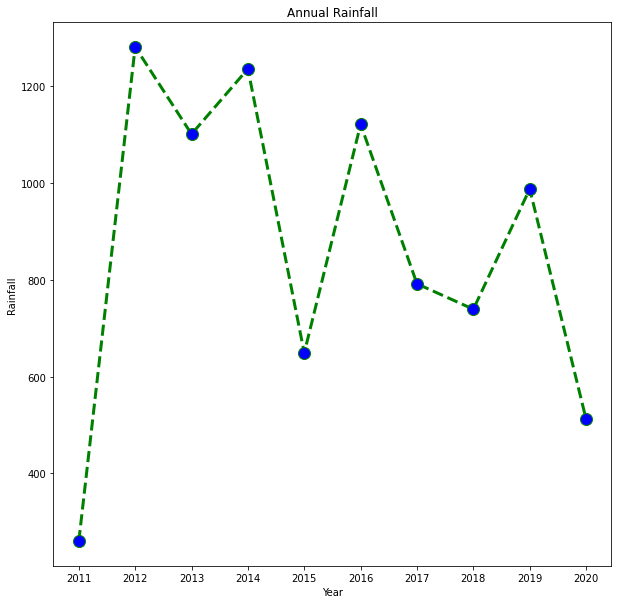

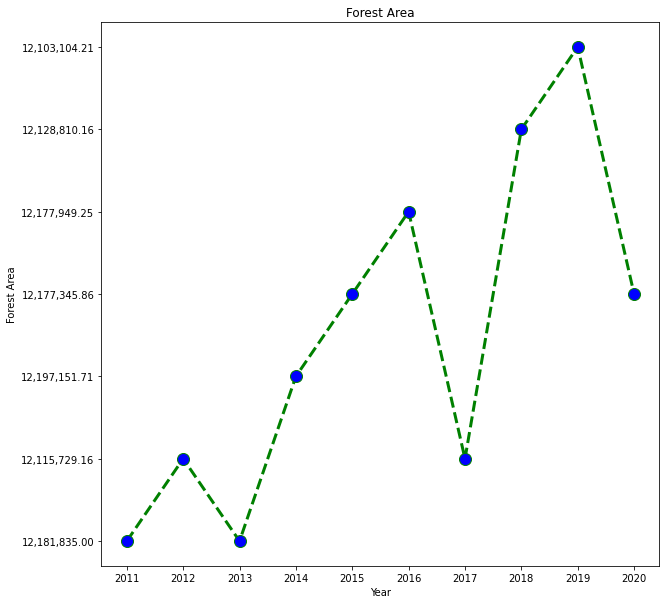

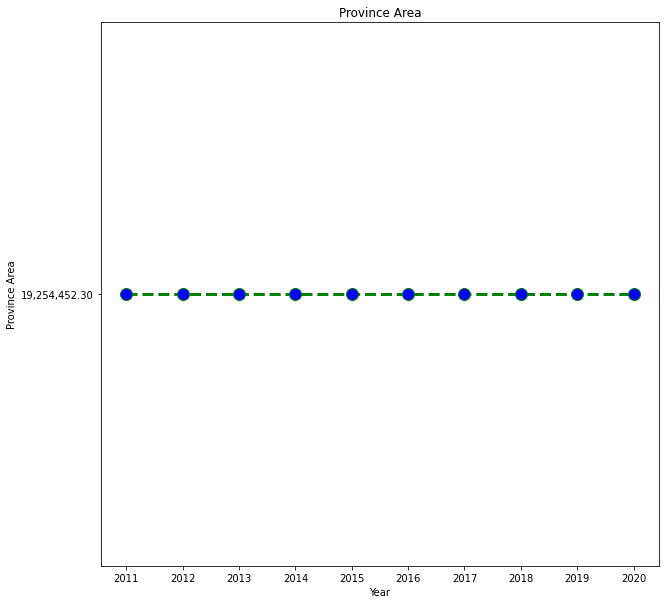

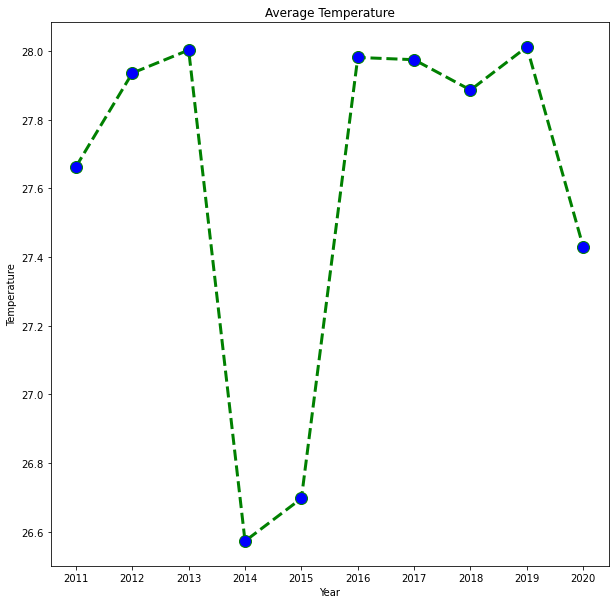

In [66]:
# plot graph north zone
plot(north_df_year['year'], north_df_year['rain1y'],"Annual Rainfall", "Year", "Rainfall")
print("\n")
plot(north_df_year['year'], north_df_year['Forest_Area'],"Forest Area", "Year", "Forest Area")
print("\n")
plot(north_df_year['year'], north_df_year['Province_Area'],"Province Area", "Year", "Province Area")
print("\n")
plot(north_df_year['year'], north_df_year['temp_out'],"Average Temperature", "Year", "Temperature")

In [67]:
#สถานีตอนกลาง
mid_df_year = transformtoPerYear(mid_df)
display(mid_df_year)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


,index,year,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,rain1y,temp_out
0,0,2011,11,WCHN,"4,051,912.64","2,515,083.57",62.07,37.93,583.4,28.092610
1,1,2012,12,WCHN,"4,051,912.64","2,593,778.11",64.01,35.99,1529.0,28.768272
2,2,2013,13,WCHN,"4,051,912.64","2,515,083.57",62.07,37.93,1069.2,28.577500
3,3,2014,14,WCHN,"4,051,912.64","2,593,778.11",64.01,35.99,889.6,28.764943
4,4,2015,15,WCHN,"4,051,912.64","2,600,029.96",64.17,35.83,723.6,29.825525
5,5,2016,16,WCHN,"4,051,912.64","2,603,324.70",64.25,35.75,1216.6,28.690699
6,6,2017,17,WCHN,"4,051,912.64","2,610,863.30",64.44,35.56,1212.6,27.758436
7,7,2018,18,WCHN,"4,051,912.64","2,623,909.73",64.76,35.24,1157.0,27.730559
8,8,2019,19,WCHN,"4,051,912.64","2,627,401.47",64.84,35.16,891.2,28.176861
9,9,2020,20,WCHN,"4,051,912.64","2,593,778.11",64.01,35.99,762.4,27.209153


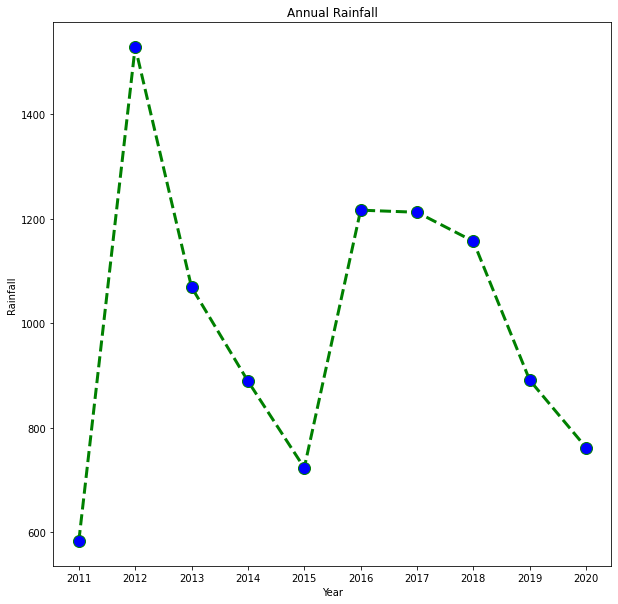

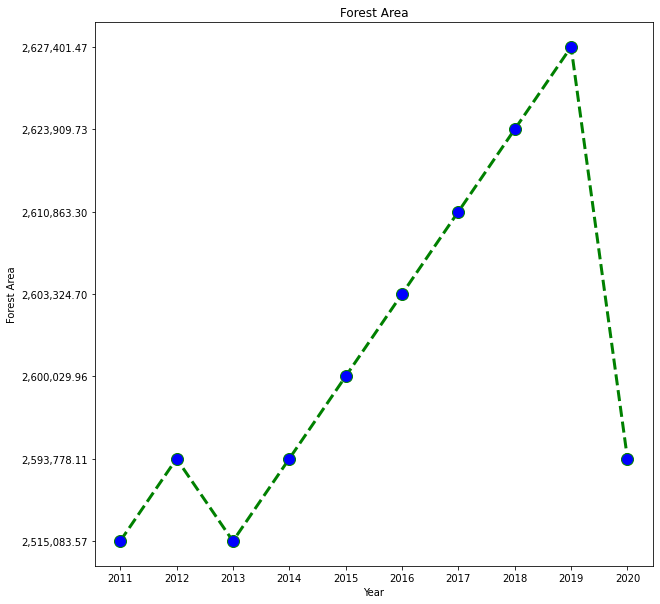

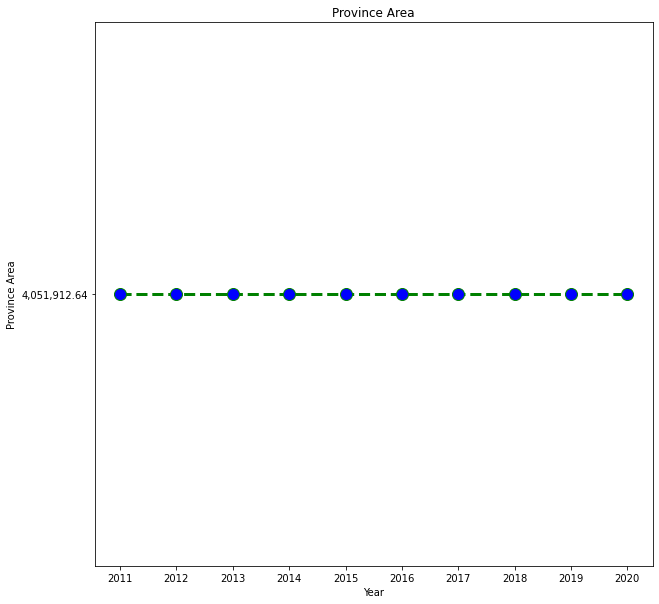

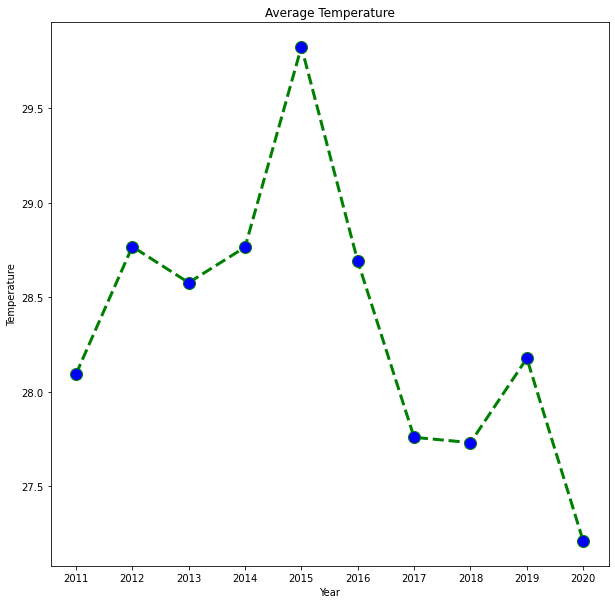

In [68]:
# plot graph mid zone
plot(mid_df_year['year'], mid_df_year['rain1y'],"Annual Rainfall", "Year", "Rainfall")
print("\n")
plot(mid_df_year['year'], mid_df_year['Forest_Area'],"Forest Area", "Year", "Forest Area")
print("\n")
plot(mid_df_year['year'], mid_df_year['Province_Area'],"Province Area", "Year", "Province Area")
print("\n")
plot(mid_df_year['year'], mid_df_year['temp_out'],"Average Temperature", "Year", "Temperature")

In [69]:
#สถานีตอนล่าง
south_df_year = transformtoPerYear(south_df)
display(south_df_year)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


,index,year,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,rain1y,temp_out
0,0,2011,11,SWKL,"84,183,434.55","41,275,108.50",551.44,748.56,491.4,29.366855
1,1,2012,12,SWKL,"84,183,434.55","41,652,816.09",564.0,736.0,935.6,31.145947
2,2,2013,13,SWKL,"84,183,434.55","41,275,108.50",551.44,748.56,839.2,30.932968
3,3,2014,14,SWKL,"84,183,434.55","41,746,553.35",565.14,734.86,1023.8,29.955023
4,4,2015,15,SWKL,"84,183,434.55","41,719,510.41",564.69,735.31,492.8,30.192123
5,5,2016,16,SWKL,"84,183,434.55","41,652,712.94",563.8,736.2,894.6,30.337580
6,6,2017,17,SWKL,"84,183,434.55","41,652,816.09",564.0,736.0,1201.2,29.780297
7,7,2018,18,SWKL,"84,183,434.55","41,728,212.55",565.64,734.36,730.4,29.315080
8,8,2019,19,SWKL,"84,183,434.55","41,661,864.73",565.03,734.97,707.4,29.368858
9,9,2020,20,SWKL,"84,183,434.55","41,661,864.73",565.03,734.97,751.8,28.930055


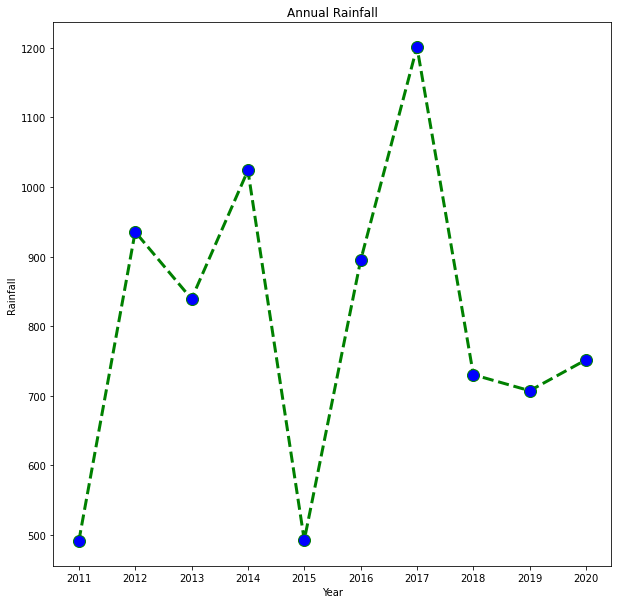

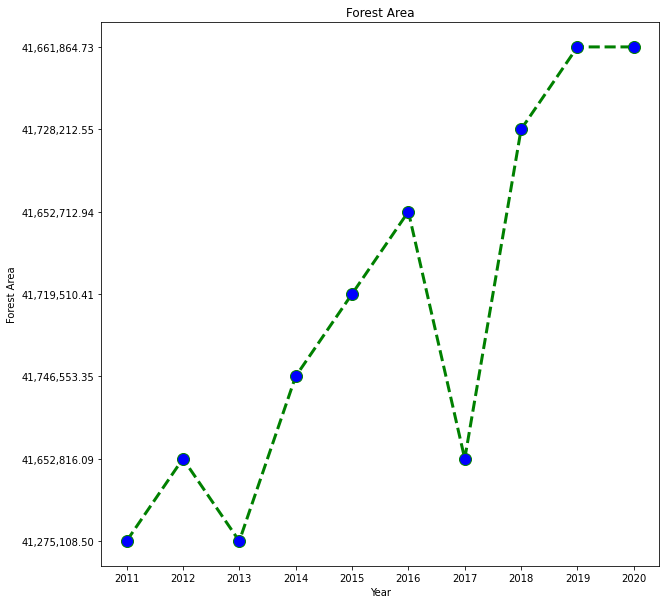

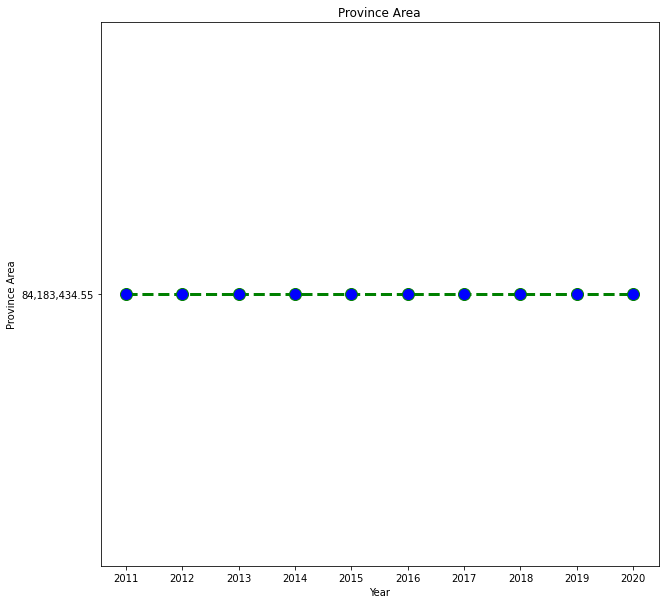

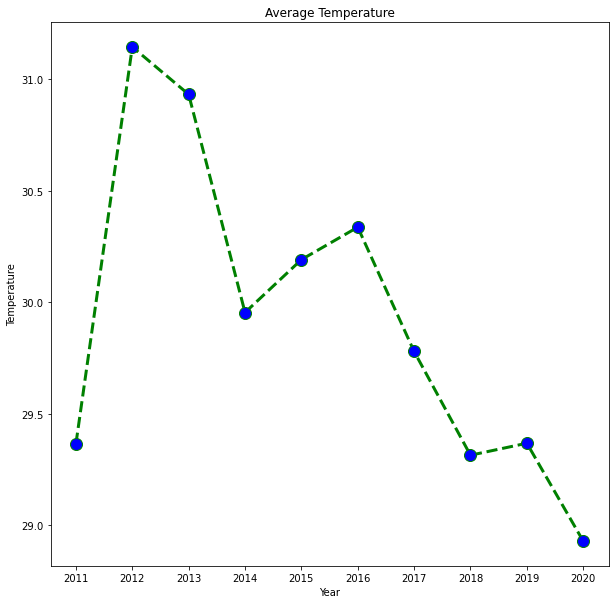

In [70]:
# plot south mid zone
plot(south_df_year['year'], south_df_year['rain1y'],"Annual Rainfall", "Year", "Rainfall")
print("\n")
plot(south_df_year['year'], south_df_year['Forest_Area'],"Forest Area", "Year", "Forest Area")
print("\n")
plot(south_df_year['year'], south_df_year['Province_Area'],"Province Area", "Year", "Province Area")
print("\n")
plot(south_df_year['year'], south_df_year['temp_out'],"Average Temperature", "Year", "Temperature")



*   Season Time Series --มิ้ม



In [ ]:
# decompose trend, seasonal, and residual
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# prep_decom = seasonal_decompose(df.Prep.values, model='additive', freq= 30)

# prep_decom.plot()

#Data Modeling

In [ ]:
# # Create get_X_y function to get dependent (y) and independent (X) variables
# def prep_data(dataframe):
  
#   dataframe['date'] = pd.to_datetime(dataframe['date'])
#   dataframe = dataframe.set_index('date')

#   # Extract time series variable
#   X = dataframe.reset_index()[['date']]
#   X['Year'] = [X.iloc[i, 0].year for i in range(len(X))]
#   X['Month'] = [X.iloc[i, 0].month for i in range(len(X))]
#   X['Day'] = [X.iloc[i, 0].day for i in range(len(X))]
#   #X['EnglishDay'] = X.Date.dt.strftime('%a')

#   # Set categorical variable
#   X = X.astype({'Month':'category', 
#                 'Day':'category'}).set_index('date')

#   # Get OHLC
#   X = X.merge(dataframe, left_index=True, right_index=True)

#   # Extract dependent variable
#   #y = dataframe[['Prep']].copy()

#   # col_drop = ['Station', 'MaxTemp', 'MaxTempTime', 'MinTemp', 'MinTempTime',
#   #                   'MaxRHTime', 'MinRHTime', 'SR', 'Prep', 'MaxSTemp5', 'MaxSTemp5Time', 'MinSTemp5', 'MinSTemp5Time',
#   #                   'MaxSTemp15', 'MaxSTemp15Time', 'MinSTemp15', 'MinSTemp15Time', 'BV','Year_y', 'MaxWGTime', 'DirectionMaxWG']
#   # X = X.drop(col_drop, axis=1)
#   #X = X.rename(columns={'Year_x' : 'Year'})
#   return X #, y

In [ ]:
X, y = get_X_y(data)
X.head()

In [ ]:
def encoding_data(X, y):
  X_encoded = pd.get_dummies(X)
  y = pd.DataFrame(y, index= y.index, columns= ['Prep'])
  return X_encoded, y

In [ ]:
#Split data

def train_test_split(dataframe, y, trainsize=0.8):

  import math

  train_ratio = trainsize
  train_size = math.ceil(len(dataframe) * train_ratio)

    # Get train dataframe
  X_train = dataframe.iloc[:train_size, :]
  y_train = y.iloc[:train_size, :]

  # Get train dataframe
  X_test = dataframe.iloc[train_size:, :]
  #X_test = dataframe.copy()
  y_test = y.iloc[train_size:, :]


  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X_encoded, y, trainsize=0.8)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y = lr.predict(X_test)

In [ ]:
#Error
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_test, y)
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

In [ ]:
def prediction_model(X_train, X_test, y_train, y_test):
  from sklearn.linear_model import LinearRegression
  from sklearn.metrics import mean_squared_error
  import math
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  
  MSE = mean_squared_error(y_test, y_pred)
  RMSE = math.sqrt(MSE)
  print("Root Mean Square Error:\n")
  print(RMSE)
  return y_pred

In [ ]:
#Visualize
def visualize(X, y, y_hat):

  # Set figure size
  plt.figure(figsize=(30, 10))

  # Plot actual price
  plt.plot(X.index, y, label='Actual Prep')

  # Plot predicted price
  plt.plot(X.index, y_hat, label='Predicted Prep')

  # Set title
  plt.title('Prep')

  # Set x-label
  plt.xlabel('Period')

  # Set y-label
  plt.ylabel('Prep')

  # Plot grid
  plt.grid()

  # Display legend
  plt.legend()

  # Display graph
  plt.show()

In [ ]:
visualize(X_test,y_test,y)

#Feature Engineering

In [ ]:
# Create feature_engineer function to extract new features
def feature_engineer(dataframe, feat_eng=False):

  if feat_eng:
    # Create a feature from previous day AvgTemp
    dataframe['PreviousDayAvgTemp'] = dataframe[['AvgTemp']].shift(periods=1,fill_value=0)

    # Create a feature from previous day VP
    dataframe['PreviousDayVP'] = dataframe[['VP']].shift(periods=1,fill_value=0)

    # Create a feature from previous day MaxRH
    dataframe['PreviousDayMaxRH'] = dataframe[['MaxRH']].shift(periods=1,fill_value=0)
    # Create a feature from previous day MinRH
    dataframe['PreviousDayMinRH'] = dataframe[['MinRH']].shift(periods=1,fill_value=0)
    # Create a feature from previous day WR
    dataframe['PreviousDayWR'] = dataframe[['WR']].shift(periods=1,fill_value=0)
    # Create a feature from previous day MaxWG
    dataframe['PreviousDayMaxWG'] = dataframe[['MaxWG']].shift(periods=1,fill_value=0)
 
  return dataframe

In [ ]:
# Test our feature_engineer function
X_engineered = feature_engineer(X, feat_eng=True)
X_engineered

#Data Pipeline

In [ ]:
def drop_range_unavailable(df):
  idx = df['rain1h'].ne(-999).idxmax()
  df = df.drop(range(0, idx))
  return df


def drop_column(df, column):
  df = df.drop(columns = column, axis = 1)
  return df


def replacwithnan(df):
  df = df.replace({-999: np.nan})
  return df

  
def fill_missing_value(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    np.random.seed(0)
    nan_rows = df[i].isna()
    random_feat = np.random.choice(df[i][~nan_rows], replace=True, size=sum(nan_rows)) 
    df.loc[nan_rows,i] = random_feat
  return df

In [ ]:
# def cleaning_data(df):
#   df = drop_range_unavailable(df)
#   df = drop_column(df, ['Province','Year'])
#   df = replacwithnan(df)
#   df = fill_missing_value(df)

In [ ]:
def prediction_model_pipeline(filename, feat_eng = True):
  #Get data
  df = getData(filename)
  df = fill_missing_value(df)
  #Get x y
  X, y = get_X_y(df)

  #Feature engineering
  X_engineered = feature_engineer(X, feat_eng=True)

  #Encoded
  X_eng_encoded, y = encoding_data(X_engineered, y)

  #Split
  X_train, X_test, y_train, y_test  = train_test_split(X_eng_encoded, y, trainsize=0.8)

  #Model
  y_pred = prediction_model(X_train, X_test, y_train, y_test)

  #Visualization
  visualize(X_test,y_test,y_pred)

In [ ]:
prediction_model_pipeline('rawdata_results_test.csv', feat_eng = True)

##Forecast Model

In [ ]:
pip install pmdarima

In [ ]:
data = getData('rawdata_results_test.csv')

In [ ]:
#Check Stationarity Data
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
ad_test(data['Prep'])

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(data['Prep'], trace=True,suppress_warnings=True)

Train model

In [ ]:
df_new = fill_missing_value(data)

In [ ]:
df_new = pd.DataFrame(df_new[['Prep']])

In [ ]:
df_new

In [ ]:
def f_train_test_split(dataframe,trainsize=0.8):

  import math

  train_ratio = trainsize
  train_size = math.ceil(len(dataframe) * train_ratio)

    # Get train dataframe
  X_train = dataframe.iloc[:train_size, :]
  #y_train = y.iloc[:train_size, :]

  # Get train dataframe
  X_test = dataframe.iloc[train_size:, :]
  #X_test = dataframe.copy()
  #y_test = y.iloc[train_size:, :]


  return X_train, X_test

In [ ]:
train, test = f_train_test_split(df_new)

In [ ]:
train.shape

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(df_new,order=(3,0,1))
model=model.fit()
model.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(figsize=(12,5),legend=True)
test['Prep'].plot(figsize=(12,5),legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# test['Prep'].mean()
rmse=sqrt(mean_squared_error(pred,test['Prep']))
print(rmse)

In [ ]:
df = fill_missing_value(data)
model2=ARIMA(df['Prep'],order=(3,0,1))
model2=model2.fit()
df.tail()

In [ ]:
index_future_dates=pd.date_range(start='2020-12-31',end='2021-03-31')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+90,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

In [ ]:
pred.plot(figsize=(12,5),legend=True)